# Store Item Demand Forecasting

# Initial imports

In [ ]:
'''%pip install ipython-autotime   --upgrade
%pip install scikit-learn       --upgrade
%pip install sktime             --upgrade
%pip install sktime[all_extras] # instala dependências que não vêm por padrão, mas são utilizadas por alguns modelos'''

In [1]:
from google.colab import drive, files
import pandas as pd
import warnings
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore")
%load_ext autotime

Mounted at /content/drive
time: 4.99 ms (started: 2023-05-22 23:49:45 +00:00)


In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/store-item-demand-forecasting/train.csv", encoding='utf-8', parse_dates=['date'])

time: 1.84 s (started: 2023-05-22 23:49:50 +00:00)


# EDA

In [ ]:
dataset

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


time: 27.6 ms (started: 2023-05-20 13:41:48 +00:00)


A tarefa é prever os três meses seguintes de vendas, mas o conjunto de dados contém registros diários. Vou transformá-lo para registros mensais. Normalmente eu faço transformações nos dados na fase de engenharia de atributos, mas como esse tipo de transformação vai influenciar até mesmo a visualização de dados, farei logo no início da análise exploratória.

**Etapa ##:** Mantenho somente os anos e meses nas datas. Os dias(01) aparecem apenas porque são definidos por padrão.

In [3]:
#dataset['date'] = dataset['date'].dt.strftime('%Y-%m') # o novo atributo se transforma em object.
#dataset["date"] = pd.to_datetime(dataset["date"])

dataset['date'] = dataset['date'].dt.to_period('M') # o novo atributo se transforma em period[M].
dataset['date'] = pd.PeriodIndex(dataset['date'], freq='M').to_timestamp()

time: 384 ms (started: 2023-05-22 23:49:58 +00:00)


**Etapa ##:** Somo a quantidade de vendas de cada item em cada loja mensalmente.

In [4]:
dataset = dataset.groupby(['store', 'item', 'date'])['sales'].sum().reset_index()
dataset = dataset[['date', 'store', 'item', 'sales']] # reordeno as colunas apenas para ficar mais legível
dataset

,date,store,item,sales
0,2013-01-01,1,1,328
1,2013-02-01,1,1,322
2,2013-03-01,1,1,477
3,2013-04-01,1,1,522
4,2013-05-01,1,1,531
...,...,...,...,...
29995,2017-08-01,10,50,2867
29996,2017-09-01,10,50,2586
29997,2017-10-01,10,50,2507
29998,2017-11-01,10,50,2574


time: 180 ms (started: 2023-05-22 23:49:59 +00:00)


**Etapa ##:** Defino as datas como sendo o index do dataframe. Também mudo o tipo de dado de index para Period que exclui o dia deixando apenas ano-mês. Este formato é necessário para o uso do sktime.

In [5]:
dataset = dataset.set_index('date')
#dataset.index = dataset.index.to_period('M')

time: 2.52 ms (started: 2023-05-22 23:50:05 +00:00)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 30000 entries, 2013-01 to 2017-12
Freq: M
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store   30000 non-null  int64
 1   item    30000 non-null  int64
 2   sales   30000 non-null  int64
dtypes: int64(3)
memory usage: 937.5 KB
time: 69.2 ms (started: 2023-05-20 23:40:39 +00:00)


In [ ]:
dataset.describe()

,store,item,sales
count,30000.000000,30000.00000,30000.000000
mean,5.500000,25.50000,1590.150400
std,2.872329,14.43111,824.119569
min,1.000000,1.00000,211.000000
25%,3.000000,13.00000,925.000000
50%,5.500000,25.50000,1449.000000
75%,8.000000,38.00000,2112.000000
max,10.000000,50.00000,5109.000000


time: 71.8 ms (started: 2023-05-20 23:40:44 +00:00)


## Data visualization

In [6]:
from sktime.forecasting.base  import ForecastingHorizon
from sktime.forecasting.trend import TrendForecaster
from sktime.utils.plotting    import plot_series

import numpy as np

np.random.default_rng()

/usr/local/lib/python3.10/dist-packages/sktime/__init__.py:45: PackageDeprecationWarning: 
The sktime PyPI package is deprecated.
The sktime project split into two projects.

To find out how to install the new packages, please go to:

* https://github.com/aeon-toolkit/aeon
* https://github.com/sktime/sktime

Here is what you can do when installing sktime via pip (e.g. using `pip install ...` or a requirement file like `requirements.txt`, `setup.py`, `setup.cfg`):

* continue using the package without receiving any updates (ignoring the deprecation warning or avoiding it by pinning the version: `sktime==0.18.0`),
* replace sktime with one of the new projects,
* if the sktime package is used by one of your dependencies, it would be great if you take some time to track which package uses sktime and report to their issue tracker that sktime is deprecated.

More information is available at:
https://github.com/mloning/sktime-deprecation/discussions/2

If the previous advice does not support 

Generator(PCG64) at 0x7FA844FA5380

time: 1.79 s (started: 2023-05-22 23:50:13 +00:00)


Considerando um ano, loja, e item quaisquer, vou fazer uma visualização mensal para verificar se há alguma sazonalidade ou tendência.

As funções da célula abaixo são úteis para fazer as visualizações. Além disso, o ideal seria criar gráficos de boa parte dos itens e lojas, mas como seriam 500 gráficos(50 itens e 10 lojas), preferi fazer de outro jeito. Através das funções abaixo, posso executar quantas vezes eu quiser as células que contem o código de visualização e cada vez um novo gráfico será criado. Este será referente a um item aleatório de uma loja aleatória podendo ser de um ano ano qualquer ou do histórico completo.

In [7]:
def get_date_range(sample):
  """
  Obtém um objeto do tipo date_rage com 'freq' definida em 'MS'. 
  Isso será fundamental para formar um ps.Series que será usado pela classe do sktime ForecastingHorizon.
  """
  start_date = sample.index[0]
  index_end  = sample.index[-1]
  return pd.date_range(start=start_date, end=index_end, freq='MS')



def get_sample_sales(dataset, one_year=True):
  """
  Forma um pd.Series com uma amostra de um ano de vendas. 
  """
  #dataset       = dataset.copy()
  #dataset.index = dataset.index.to_timestamp()

  dataset_sample = random_sample_sales(dataset, one_year)
  date_range     = get_date_range(dataset_sample)
  
  sales       = dataset_sample['sales']
  sales.index = date_range
  return sales



def random_sample_sales(dataset, one_year=True):
  """
  Obtém uma amostra aleatória correspondente a um ano de vendas do dataset ou ao histórico interio.
  """
  store = np.random.randint(1, 11)
  item  = np.random.randint(1, 51)
  year  = np.random.randint(2013, 2018)
  
  if one_year:
    mask  = (dataset.index.year == year) & (dataset['store'] == store) & (dataset['item'] == item)
  else:
    mask  = (dataset['store'] == store) & (dataset['item'] == item)
  return dataset[mask]

time: 1.35 ms (started: 2023-05-22 23:50:20 +00:00)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

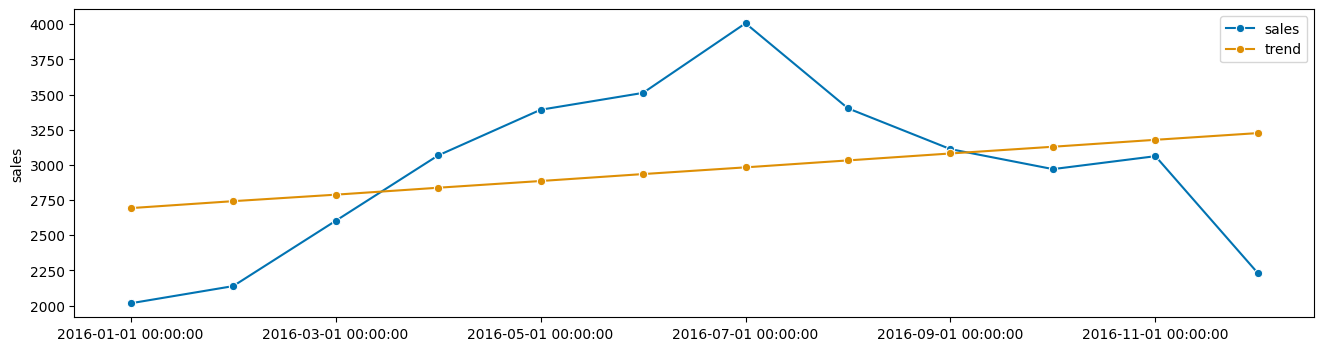

time: 306 ms (started: 2023-05-22 18:22:02 +00:00)


In [ ]:
# Cada vez que essa célula for executada ela criará um gráfico diferente.
sales = get_sample_sales(dataset, one_year=True)

fh = ForecastingHorizon(sales.index, is_relative=False)
ds = TrendForecaster()
ds.fit(sales)
trend = ds.predict(fh=fh)

plot_series(sales, trend, labels=['sales', 'trend'])

**Conclusão:** Executando várias vezes a célula acima podemos concluir que não há sazonlidade mensal de vendas e uma leve tendência crescente em alguns anos. 

Há, no entanto, um pico de vendas sempre em torno do mês 7. Considerando que esse conjunto de dados é americano, esse padrão se deve, provavelmente, por causa do verão e das férias.

Agora, vou escolher uma loja e um item qualquer para analisar o histórico de vendas ao longo de todos os anos registrados mês a mês.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

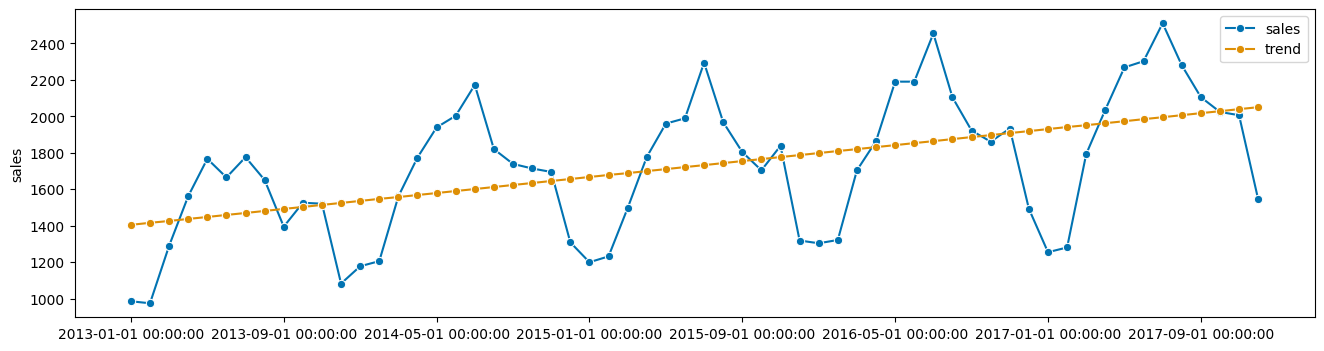

time: 835 ms (started: 2023-05-22 18:18:25 +00:00)


In [ ]:
sales = get_sample_sales(dataset, one_year=False)

fh = ForecastingHorizon(sales.index, is_relative=False)
ds = TrendForecaster()
ds.fit(sales)
trend = ds.predict(fh=fh)

plot_series(sales, trend, labels=['sales', 'trend'])

**Conclusão:** Executando várias vezes a célula acima, é possível observar sazonalidade ao longo dos anos com picos sempre por volta do mês 7 e vales sempre no ínicio e fim de cada ano. Também conseguimos ver uma leve tendência de aumento de vendas no decorrer do tempo.

# Train/Test split

Meu conjunto de teste será correspondente a um ano. Como sei que o último ano é 2017, vou usar os 12 meses dele.

In [8]:
from sktime.forecasting.model_selection import temporal_train_test_split

time: 4.7 ms (started: 2023-05-22 23:50:27 +00:00)


In [ ]:
fh = ForecastingHorizon(values=pd.period_range('2017-01', periods=12, freq='M'), is_relative=False)
fh

ForecastingHorizon(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
            dtype='period[M]', is_relative=False)

time: 5.71 ms (started: 2023-05-21 00:22:01 +00:00)


A célula acima só está presente para registro porque não será usada. A função temporal_train_test_split(fh=fh) estava multiplicando 400 vezes o tamanho do conjunto de treinamento. O conjunto de teste foi formado corretamente. No lugar de fh, resolvi estabelecer um número para o parâmetro test_size que seja o suficiente para capturar todos os registros de 2017 seguindo a seguinte lógica:

*   os registros são mensais;
*   um ano possui 12 meses;
*   um item de uma loja é registrado 12 vezes em um ano, mas são 50 itens existente no conjunto de dados, então, 50 * 12 = 600 registros;
*   considerando 10 lojas, temos 600 * 10 = 6000

A última coisa antes de chamar a função é ordenar os as datas crescentemente, para que os 6000 registros correspondentes a 2017 fiquem por último.



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

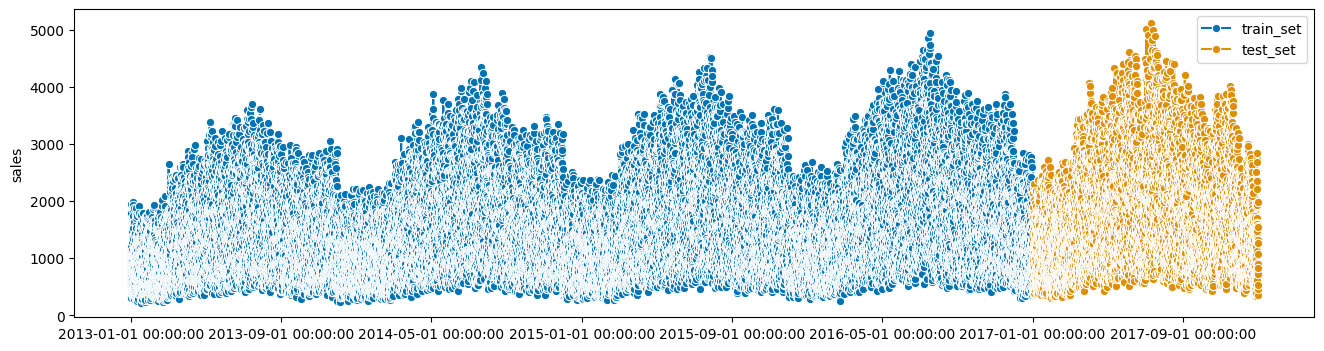

time: 3.07 s (started: 2023-05-22 23:50:54 +00:00)


In [9]:
train_set, test_set = temporal_train_test_split(dataset.sort_index(), test_size=6000)
plot_series(train_set['sales'], test_set['sales'], labels=['train_set', 'test_set'])

# Feature engineering.

In [40]:
from scipy.stats             import boxcox
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import MinMaxScaler, OrdinalEncoder, PowerTransformer

import math
import numpy as np

time: 1.14 ms (started: 2023-05-23 00:06:43 +00:00)


**Etapa ##:** Reordeno os conjuntos para que suas datas sejam progressivas ao longo do tempo.

In [11]:
train_set = train_set.sort_values(['store', 'item'])
test_set  = test_set.sort_values(['store', 'item'])
train_set

,store,item,sales
2013-01-01,1,1,328
2013-02-01,1,1,322
2013-03-01,1,1,477
2013-04-01,1,1,522
2013-05-01,1,1,531
...,...,...,...
2016-08-01,10,50,2842
2016-09-01,10,50,2568
2016-10-01,10,50,2495
2016-11-01,10,50,2581


time: 22 ms (started: 2023-05-22 23:51:09 +00:00)


**Etapa ##:** Crio as labels. Para cada registro, adiciono a quantidade de vendas feitas no primeiro, segundo e terceiro mês seguinte. 

Obs. A classe abaixo servirá tanto para lag quanto para forward features.

In [13]:
class LagForwardFeatures(BaseEstimator, TransformerMixin):
  """
  Cria uma quantidade n de lag ou forward features.
  """
  def __init__(self, lag_size=0):
    if lag_size < 0:
      self.init = lag_size
      self.end  = 0
      self.lag_forward = 'forward'
    else:
      self.init = 1
      self.end  = lag_size + 1
      self.lag_forward = 'lag'

  def fit(self, X, y=None):
    return self
    
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X = X.copy()
    for i in range(self.init, self.end):
      col_name = 'sales_' + self.lag_forward + '_' + str(np.abs(i))
      X[col_name] = X.groupby(['store', 'item'])['sales'].shift(i)
    return X

time: 1.11 ms (started: 2023-05-22 23:52:36 +00:00)


A etapa abaixo não fará parte do pipeline de transformações. Ela serve apenas para criar as labels e extraí-las de ambos conjuntos de treinamento e teste.

In [17]:
fwrd_feat = LagForwardFeatures(lag_size=-3)
train_set = fwrd_feat.fit_transform(train_set)
test_set  = fwrd_feat.transform(test_set)
y_train   = train_set[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_train   = train_set.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)
y_test    = test_set[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_test    = test_set.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)
y_train   = y_train.fillna(0)
y_test    = y_test.fillna(0)

time: 27.6 ms (started: 2023-05-22 23:57:36 +00:00)


---

As transformações abaixo farão parte do pipeline de transformações.

**Etapa ##:** Crio lag features com os três meses de vendas anteriores.


In [21]:
pp_lag = Pipeline(steps=[('lag_features', LagForwardFeatures(lag_size=3))])

time: 680 µs (started: 2023-05-23 00:00:32 +00:00)


**Etapa ##:** Extraio novos atributos a partir das datas.
1.   Ano
2.   Mês
4.   Estações do ano
5.   Quartis de cada ano.


In [22]:
class DatesFeatures(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_season(self, month):
    if month in [12, 1, 2]:
      return "Winter"
    elif month in [3, 4, 5]:
      return "Spring"
    elif month in [6, 7, 8]:
      return "Summer"
    else:
      return "Fall"

  def transform(self, X, y=None):
    X = X.copy()
    #X = X.assign(season=X.index.month.map(self.get_season))
    X['year']    = X.index.year
    X['month']   = X.index.month
    X['season']  = np.vectorize(self.get_season)(X.index.month)
    X['quarter'] = X.index.to_period('Q')
    return X

time: 2.43 ms (started: 2023-05-23 00:00:35 +00:00)


In [23]:
pp_dates = Pipeline(steps=[('dates_features', DatesFeatures())])

time: 649 µs (started: 2023-05-23 00:00:42 +00:00)


**Etapa ##:** Crio atributos contendo a diferença de vendas entre o mês corrente e os três meses anteriores e outras medidas estatísticas, como:

*   Maior valor entre a quantidade de vendas corrente e as dos três meses anteriores.
*   Menor valor entre a quantidade de vendas corrente e as dos três meses anteriores.
*   Média de vendas entre a corrente e as dos três meses anteriores.
*   Desvio padrão de vendas entre a corrente e as dos três meses anteriores.

Essas medidas estatísticas podems ajudar o modelo preditor, mas não é uma certeza.

In [24]:
class StatisticSales(BaseEstimator, TransformerMixin):
  """
  Calcula estatísticas de um conjunto de dados, como: 
  * diferença entre o valor corrente e n passos atrás
  * max(), min(), mean(), std() entre o valor atuale n passos atrás
  """
  def __init__(self, size=0):
    self.size = size + 1

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_diff(self, X, y=None):
    for i in range(1, self.size):
      col_name = 'sales_diff_' + str(i)
      X[col_name] = X.groupby(['store', 'item'])['sales'].diff(i)
    return X

  def get_stats(self, X, y=None):
    for i in range(2, self.size + 1): # precisa ser +1 porque rolling considera também a linha corrente
      max_name  = 'sales_max_'  + str(i - 1)
      min_name  = 'sales_min_'  + str(i - 1)
      mean_name = 'sales_mean_' + str(i - 1)
      std_name  = 'sales_std_'  + str(i - 1)
      X[max_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).max().reset_index(level=[0, 1], drop=True)
      X[min_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).min().reset_index(level=[0, 1], drop=True)
      X[mean_name] = X.groupby(['store', 'item'])['sales'].rolling(i).mean().reset_index(level=[0, 1], drop=True)
      X[std_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).std().reset_index(level=[0, 1], drop=True)
    return X

  def transform(self, X, y=None):
    X = X.copy()
    X = self.get_diff(X)
    X = self.get_stats(X)
    return X

time: 4.2 ms (started: 2023-05-23 00:00:42 +00:00)


In [25]:
pp_stats = Pipeline(steps=[('stats_features', StatisticSales(size=3))])

time: 788 µs (started: 2023-05-23 00:00:47 +00:00)


**Etapa ##:** O conjunto de dados possui datas de 2013 até 2017 se repetindo em forma de ciclos inúmeras vezes. Isso acontece por causa das lojas e itens. Para fazer com que os modelos de machine learning entendam esses ciclos eu codifico os atributos cíclicos(year, month, season, quarter) decompondo-os em componentes seno e conseno. Só depois disso posso remover o atributo 'date' do conjunto.

In [26]:
class CyclicEncoder(BaseEstimator, TransformerMixin):
  """
  Esta classe deve ser usada sozinha ou dentro de um Pipeline.
  """
  def __init__(self, cyclical_cols):
    self.cyclical_cols = cyclical_cols

  def create_cyclic_names(self):
    cols_names = []
    for name in self.cyclical_cols:
      cols_names.append("sin_" + name)
      cols_names.append("cos_" + name)
    return cols_names
    
  def fit(self, X, y=None):
    ordinal_encoder = OrdinalEncoder()
    self.X_ordinal = ordinal_encoder.fit_transform(X[self.cyclical_cols])    
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X = X.copy()
    X_aux = []
    cols = range(self.X_ordinal.shape[1])
    for index in cols:
      column = self.X_ordinal[:, index]
      max_value = column.max()
      sin_values = [math.sin((2 * math.pi * x) / max_value) for x in list(column)]
      cos_values = [math.cos((2 * math.pi * x) / max_value) for x in list(column)]
      X_aux.append(sin_values)
      X_aux.append(cos_values)
    X_encoded = np.array(X_aux).transpose()
    cyclical_features = pd.DataFrame(data=X_encoded, columns=self.create_cyclic_names())
    cyclical_features = cyclical_features.set_index(X.index)
    X = pd.concat([cyclical_features, X], axis=1)
    return X.drop(self.cyclical_cols, axis=1)

time: 2.56 ms (started: 2023-05-23 00:00:50 +00:00)


In [27]:
pp_cyclical = Pipeline(steps=[('cyclical_encoding', CyclicEncoder(['year', 'month', 'season', 'quarter']))])

time: 515 µs (started: 2023-05-23 00:00:54 +00:00)


**Etapa ##:** Imputo valores nos registros que contém NaN.

In [28]:
pp_imputer = Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='constant', fill_value=0))])

time: 675 µs (started: 2023-05-23 00:01:06 +00:00)


**Etapa ##:** Coloco todos os número os números na mesma escala.

In [29]:
pp_scaler = Pipeline(steps=[('min_max_scaler', MinMaxScaler())])

time: 562 µs (started: 2023-05-23 00:01:09 +00:00)


**Etapa ##:** Faço um transformação em cada coluna para que cada uma tenha uma distribuição próxima da distribuição normal.

In [ ]:
class BoxCox(BaseEstimator, TransformerMixin):
  """
  Necessário para o boxcox ou log
  COL + 1 - np.min(COL)      se houver números negativos(x < 0)
  COL + 1                    se não houver números negativos(x >= 0) 
  """
  def fit(self, X, y=None):
    return self
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)
    
  def transform(self, X, y=None):
    cols_names = X.columns
    for name in cols_names:
      if np.any(X[name].values < 0):
        X[name] = X[name] + 1 - X[name].min()
      else:
        X[name] = X[name] + 1
    for name in cols_names:
      col_boxcox = boxcox(X[name])[0]
      X[name] = pd.Series(col_boxcox)
    return X

In [30]:
pp_transformer = Pipeline(steps=[('power', PowerTransformer(method='box-cox'))])

time: 591 µs (started: 2023-05-23 00:01:25 +00:00)


## Etapa final: Pipeline completo

In [37]:
steps = [('pp_lag', pp_lag), 
         ('pp_dates', pp_dates), 
         ('pp_stats', pp_stats), 
         ('pp_cyclical', pp_cyclical), 
         ('pp_imputer', pp_imputer), 
         ('pp_scaler', pp_scaler), ]

pipeline_full = Pipeline(steps=steps)
X_train_     = pipeline_full.fit_transform(X_train)
X_test_      = pipeline_full.fit_transform(X_test)

time: 2.29 s (started: 2023-05-23 00:03:26 +00:00)


# Model training
Para cada tipo de modelo vou treinar três instâncias diferentes. Cada instância vai prever um mês diferente à frente.

1.   modelo_a: 1 mês à frente;
2.   modelo_b: 2 meses à frente;
3.   modelo_c: 3 meses à frente.



In [ ]:
from sklearn.base     import clone
from sklearn.metrics  import mean_squared_error
from xgboost          import XGBRegressor

import lightgbm as lgb
import numpy as np

time: 697 µs (started: 2023-05-05 13:40:53 +00:00)


## Custom cross validation

In [ ]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error between the true and predicted values.   
    
    Returns (The lower the better):
    float: The SMAPE score between 0 and 100.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    numerator = np.abs(y_pred - y_true)
    
    return np.mean(numerator / denominator) * 100

time: 888 µs (started: 2023-05-05 13:40:53 +00:00)


In [ ]:
def custom_cross_val(model, dataset, pipeline, label_name):
  scores = list()
  tss = TimeSeriesSplit(n_splits=5)
  for train_indexes, val_indexes in tss.split(dataset):
    train_set       = dataset.iloc[train_indexes]
    validation_set  = dataset.iloc[val_indexes]

    if pipeline:
      train_set       = pipeline.fit_transform(train_set)
      validation_set  = pipeline.transform(validation_set)

    y_train = train_set[label_name]
    X_train = train_set.drop(label_name, axis=1)

    y_val = validation_set[label_name]
    X_val = validation_set.drop(label_name, axis=1)

    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    y_pred = model_clone.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)
  return scores

time: 1.25 ms (started: 2023-05-05 13:40:53 +00:00)


Abaixo, a visualização dos folds que serão usados na validação cruzada.

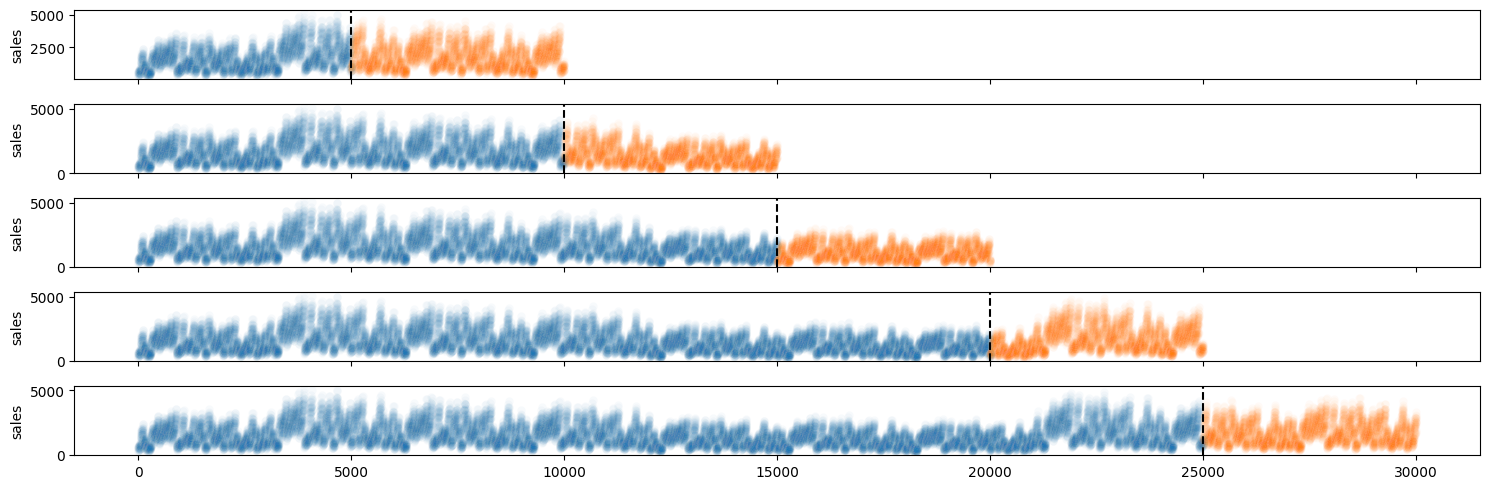

time: 2.56 s (started: 2023-05-05 13:40:53 +00:00)


In [ ]:
tss = TimeSeriesSplit(n_splits=5)

fig, axs = plt.subplots(5, 1, figsize=(15, 5), sharex=True)
axs = axs.ravel()
index = 0

for train_indexes, test_indexes in tss.split(train):
  train_set = train.iloc[train_indexes]
  test_set  = train.iloc[test_indexes]
  axs[index].axvline(test_set.index.min(), color='black', ls='--')
  sns.scatterplot(x=train_set.index, y=train_set['sales'], ax=axs[index], alpha=0.03)
  sns.scatterplot(x=test_set.index, y=test_set['sales'], ax=axs[index], alpha=0.03)
  index += 1
  
plt.tight_layout()
plt.show()

## LGBMRegressor

In [ ]:
scores = custom_cross_val(lgb.LGBMRegressor(), train, None, 'sales')
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

Mean RMSE: 54.35
Std Dev:   4.65
time: 1.89 s (started: 2023-05-05 13:40:55 +00:00)


In [ ]:
# Train separate LightGBM models for each target variable
lgbm_l1 = lgb.LGBMRegressor()
lgbm_l2 = lgb.LGBMRegressor()
lgbm_l3 = lgb.LGBMRegressor()

lgbm_l1.fit(X_train, y_train.iloc[:,0])
lgbm_l2.fit(X_train, y_train.iloc[:,1])
lgbm_l3.fit(X_train, y_train.iloc[:,2])

# Make predictions on the test data
y_pred_l1 = lgbm_l1.predict(X_train)
y_pred_l2 = lgbm_l2.predict(X_train)
y_pred_l3 = lgbm_l3.predict(X_train)
y_pred = np.column_stack((y_pred_l1, y_pred_l2, y_pred_l3))

# Evaluate the model using SMAPE
smape_score = smape(y_train, y_pred)
print("SMAPE score: {:.2f}%".format(smape_score))

SMAPE score: 3.20%
time: 1.21 s (started: 2023-05-05 13:45:52 +00:00)


In [ ]:
# Make predictions on the test data
y_pred_l1 = lgbm_l1.predict(X_test)
y_pred_l2 = lgbm_l2.predict(X_test)
y_pred_l3 = lgbm_l3.predict(X_test)
y_pred = np.column_stack((y_pred_l1, y_pred_l2, y_pred_l3))

# Evaluate the model using SMAPE
smape_score = smape(y_train, y_pred)
print("SMAPE score: {:.2f}%".format(smape_score))

## XGBRegressor

In [ ]:
scores = custom_cross_val(XGBRegressor(), train, None, 'sales')
print(f'Mean RMSE: {np.mean(scores):.2f}')
print(f'Std Dev:   {np.std(scores):.2f}')

In [ ]:
n_samples = len(train)
print(n_samples)
print(n_samples // 5)
print(((n_samples // 5) / n_samples) * 100)

In [ ]:
print(n_samples /5)
print((n_samples/ 5) * 0.25)